# Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests (ANOVA). The methods based on F-test estimate the degree of linear dependency between two random variables. They assume a linear relationship between the feature and the target. These methods also assume that the variables follow a Gaussian distribution.

These may not always be the case for the variables in your dataset, so if looking to implement these procedure, you will need to corroborate these assumptions.

I will demonstrate how to select features based on univariate tests using sklearn on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

For the sake of the demonstration, I will assume that the variables show a linear relationship with the target, and that they are normally distributed. But when or if you choose to implement these selection procedure for your features, you will have to check that this is the case, to make sure you are implementing the right method.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import f_classif, f_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

### GLOBAL VARIABLES

In [7]:
INPUT_PATH = '../../data/train_test'
OUTPUT_PATH = '../../data/features'
INPUT_FILE_NAME = 'filter_features_correlation_v008'
OUTPUT_FILE_NAME = 'filter_features_univariate_v008'
SEED = 47
CUTOFF = 0.9

### FUNCTIONS

In [3]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

### LOAD DATASET

##### Important

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [4]:
# load the Santander customer satisfaction dataset from Kaggle
X_train = pd.read_pickle(f'{INPUT_PATH}/X_train.pkl').pipe(reduce_mem_usage)
y_train = pd.read_pickle(f'{INPUT_PATH}/Y_train.pkl')

In [5]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (20580750, 124)
y_train:  (20580750,)


In [8]:
features = np.load(f'{OUTPUT_PATH}/{INPUT_FILE_NAME}.npy').tolist()

In [9]:
X_train = X_train[features]

In [10]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (20580750, 65)
y_train:  (20580750,)


In [11]:
X_train['target'] = y_train.values

In [12]:
features_init = X_train.columns.tolist()

### SAMPLE DATASET

In [13]:
X_train = X_train.groupby(['item_id', 'store_id']).apply(lambda x: pd.DataFrame.sample(x, frac=.3, random_state=SEED))

In [14]:
y_train = X_train.target

In [15]:
X_train.drop('target', axis=1, inplace=True)

In [16]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (6158980, 65)
y_train:  (6158980,)


### SELECT NUMERIC FEATURES

In [17]:
catfeatures = set(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'month', 'week', 'year'])

In [18]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(X_train.select_dtypes(include=numerics).columns)
X_train = X_train[numerical_vars]

In [19]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (6158980, 65)
y_train:  (6158980,)


## CLASSIFICATION

In [6]:
# calculate the univariate statistical measure between
# each of the variables and the target
# similarly to chi2, the output is the array of f-scores
# and an array of pvalues, which are the ones we will compare

univariate = f_classif(X_train.fillna(0), y_train)
univariate

(array([  2.11162492e+01,   5.06903417e+00,   4.27818275e+00,
          1.95927569e+01,   8.53173465e+00,   1.54298512e+01,
          5.46509341e+00,   3.04682965e+01,   8.24285946e+02,
          2.68913033e+01,   9.66316909e+01,   3.19551560e+01,
          6.33578816e+02,   3.81883239e+01,   2.66401706e+01,
          3.21455592e-01,   5.48803980e+00,   3.13932541e+01,
          2.39185299e+01,   9.98605317e+01,   2.38686426e+01,
          5.13173713e+00,   1.14013701e+01,   1.47892193e+01,
          2.09524865e+01,   1.82398726e+01,   3.47714707e+01,
          5.14114122e+01,   3.36632813e+02,   2.50797299e+01,
          4.91492071e+01,   2.84653396e+01,   1.48795180e+02,
          1.83116171e+00,   3.93028656e+01,   2.20369384e+01,
          2.60488115e+01,   1.35485945e+01,   1.22121075e+01,
          3.79558867e+01,   6.12330299e+00,   4.72631041e+01,
          2.57529828e+01,   2.25353557e+03,   6.30730647e+01,
          2.71971830e+01,   3.57244547e+00,   5.47203890e+01,
        

In [7]:
# let's add the variable names and order it for clearer visualisation
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False, inplace=True)

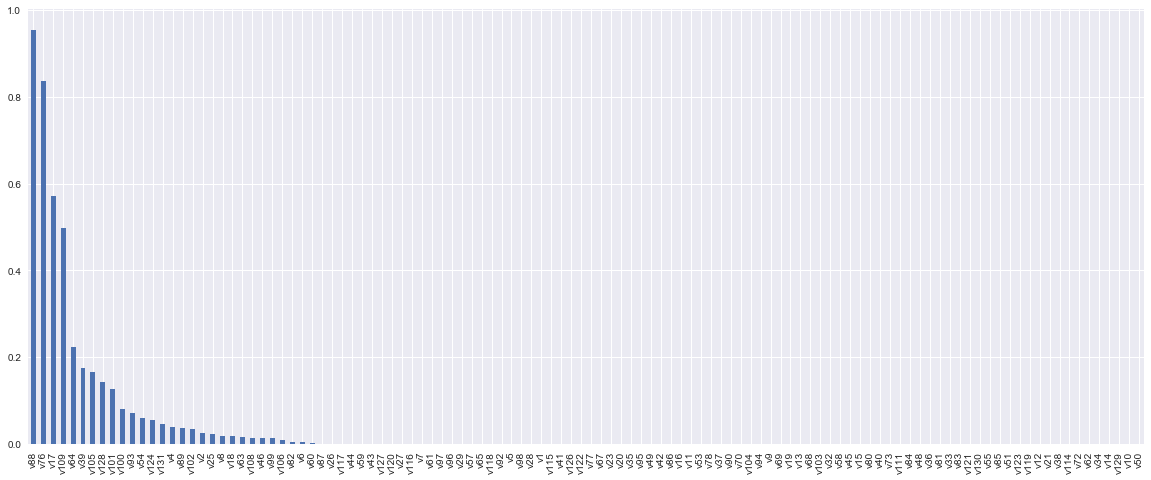

In [8]:
# and now let's plot the p values
univariate.sort_values(ascending=False).plot.bar(figsize=(20, 8))
pass

Remember that the lower the p_value, the most predictive the feature is in principle. There are a few features that do not seem to have predictive power according to this tests, which are those on the left with pvalues above 0.05. Given that typically in statistics one uses a pvalue of 0.05 as a cut-off, I am inclined to believe that those features with pvalue > 0.05 are indeed not important. However, keep in mind that this test assumes a linear relationship, so it might also be the case that the feature is related to the target but not in a linear manner.

Further investigation is needed if we want to know the true nature of the relationship between feature and target.

Similarly to what I mentioned in the previous lecture, in big datasets it is not unusual that the pvalues of the different features are really small. This does not say as much about the relevance of the feature. Mostly it indicates that it is a big the dataset.

Once again, where we put the cut-off to select features is a bit arbitrary. One way is to select the top 10, 20 features. Alternatively, the top 10th percentile. For this, you can use anova in combination with SelectKBest or SelectPercentile from sklearn. See below.

In [9]:
# here I will select the top 10 features
sel_ = SelectKBest(f_classif, k=10).fit(X_train.fillna(0), y_train)
X_train.columns[sel_.get_support()]

Index(['v10', 'v14', 'v21', 'v34', 'v38', 'v50', 'v62', 'v72', 'v114', 'v129'], dtype='object')

In [10]:
X_train = sel_.transform(X_train.fillna(0))
X_train.shape

(35000, 10)

## REGRESSION

In [22]:
univariate = f_regression(X_train.replace([np.inf, -np.inf], np.nan).fillna(0), y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False, inplace=True)

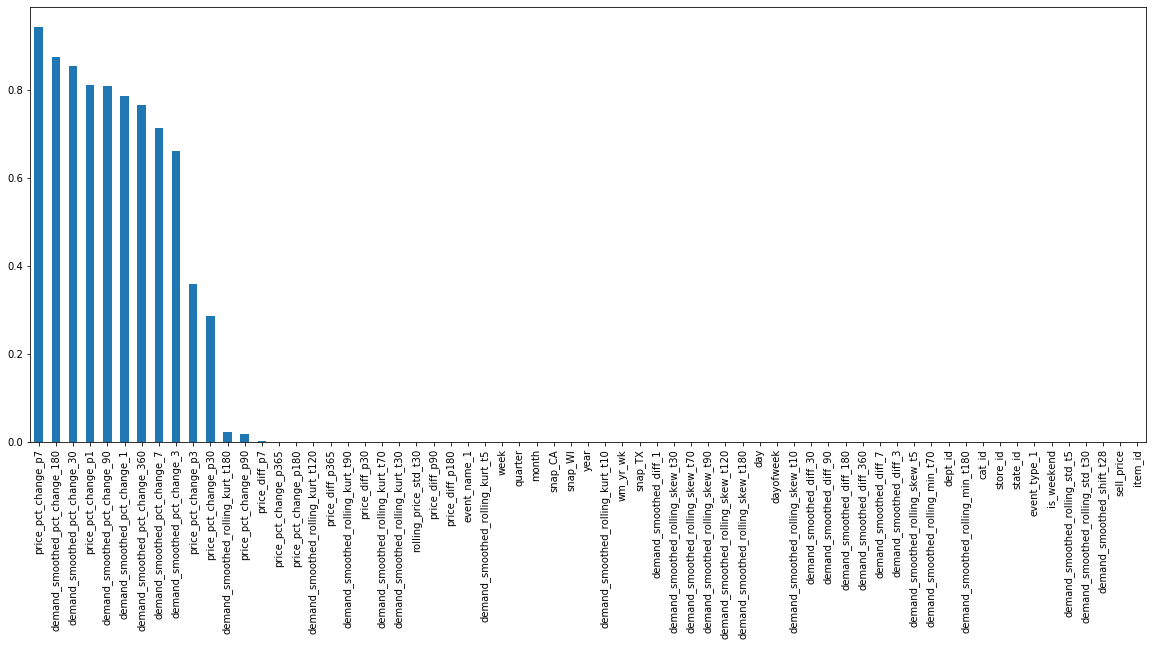

In [23]:
univariate.sort_values(ascending=False).plot.bar(figsize=(20,8))
pass

Here again, there seem to be a bunch of features towards the left with pvalues above 0.05, which are candidates to be removed, as this means that the features do not statistically significantly discriminate the target.

In [34]:
# here I will select the top 10 percentile
sel_ = SelectPercentile(f_regression, percentile=10).fit(X_train.fillna(0), y_train)
X_train.columns[sel_.get_support()]

Index(['demand_smoothed_shift_t28', 'demand_smoothed_rolling_std_t5',
       'demand_smoothed_rolling_std_t30', 'demand_smoothed_rolling_min_t70'],
      dtype='object')

In [35]:
X_train = sel_.transform(X_train.fillna(0))
features_final = list(X_train.columns)

(6158980, 4)

In [ ]:
print(len(features) - len(features_final), " were removed. The number of final features is ", len(features_final))

In [ ]:
# saving final features
np.save(f'{OUTPUT_PATH}/{OUTPUT_FILE_NAME}.npy',features_final)

I would say again that I rarely use these methods to select features. I do use them though when investigating the relationship of specific variables  with the target in bespoke problems that do not necessarily culminate in machine learning model building.

In any case, I wanted to have them covered in the course and you can play with them and see if you find them useful.

That is all for this lecture, I hope you enjoyed it and see you in the next one!